<div style="background-image:url('../share/images/header.svg'); padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height: 250px">
    <div style="float:right; margin: 50px; padding: 20px; background:rgba(255,255,255,0.7); width: 50%; height: 150px">
        <div style="position:relative; top:50%; transform: translateY(-50%)">
            <div style="font-size: xx-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">Rotational Seismology</div>
            <div style="font-size: large; padding-top: 20px; color:rgba(0,0,0,0.5)">Estimate Event Backazimuth</div>
        </div>
    </div>
</div>

![](images/obspy_logo_full_524x179px.png)

Seismo-Live: http://seismo-live.org

##### Authors:
* Johannes Salvermoser ([@salve-](https://github.com/salve-))

---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 8

### 1 Load pre-processed waveforms and event-xml

Waveforms of transverse acceleration and vertical rotation rate are loaded from the repository. <br>
They were pre-processed as described in the **Data Download + Pre-processing**-Tutorial. <br>
That means they are:
<ul> <li>instrument corrected</li>
<li>resampled (decimation factor: 4)</li>
<li>filtered (lowpass: $f_{cutoff}$ = 2 Hz)</li>
</ul><br>
We also need the locations of station and event epicenter to obtain the theoretical backazimuth.

In [2]:
from obspy import read, read_events
from obspy.geodetics.base import gps2dist_azimuth
import numpy as np

AC = read('data/acc_Turkey_preproc.mseed')
RLAS = read('data/rot_Turkey_preproc.mseed')
cat = read_events('data/xml_Turkey.xml')
event = cat[0]

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (Wettzell)
station_latitude = 49.144001
station_longitude = 12.8782

print(cat)
print(event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'])

1 Event(s) in Catalog:
2011-10-23T10:41:27.500000Z | +38.640,  +43.400 | 7.1 MW
Flinn-Engdahl region :  TURKEY


** Obtain the theoretical backazimuth via gps2distazimuth**

In [3]:
# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

print('Epicentral distance [m]: ',np.round(baz[0],1))
print('Theoretical azimuth [deg]: ', np.round(baz[1],1))
print('Theoretical backazimuth [deg]: ', np.round(baz[2],1))

Epicentral distance [m]:  2691458.3
Theoretical azimuth [deg]:  305.6
Theoretical backazimuth [deg]:  104.1


### 2 Estimate correlation coefficients and backazimuth for each time window
The estimation of the backazimuth (BAz = source direction angle) is based on *Igel et al.(2007)* and illustrated <br>
as a simple example here:<br>

We define the length of the time windows, we want to use and calculate the number of time windows for <br>
our downloaded and pre-processed waveform data. <br>

For each time-window, we rotate the horizontal acceleration components through all possible <br>
source directions (BAz, 0-360°) in **10°-steps**. In each of the steps, we check the similarity (phase-match) between <br>
vertical rotation rate and the rotated acceleration by cross-correlation (X-corr).<br>

The rotation angle/ BAz-value yielding the highest correlation coefficient for the specific time window rotates the <br> horizontal acceleration components to radial/ transverse (= into the angular direction of the strongest signal source).<br>
That's exactly what *McLeod et al. (1998) and Pancha et al. (2000)* showed for Love waves:<br>

**Vertical rotation rate and transverse acceleration are in phase!**

In [4]:
from obspy.signal.cross_correlation import xcorr
from obspy.signal.rotate import rotate_ne_rt

sampling_rate = int(RLAS[0].stats.sampling_rate)
sec = 60  # window length for correlation
num_windows = len(RLAS[0]) // (int(sampling_rate * sec))

# estimate the Backazimuth for each time window
step = 10
backas = np.linspace(0, 360 - step, 360 / step)
corrbaz = []
ind=None
for i_deg in range(0, len(backas)):
    for i_win in range(0, num_windows):
        corrbazz = xcorr(RLAS[0][sampling_rate * sec * i_win : sampling_rate * sec * (i_win + 1)],
                             rotate_ne_rt(AC.select(component='N')[0].data,
                                          AC.select(component='E')[0].data, backas[i_deg])
                             [1][sampling_rate * sec * i_win : sampling_rate * sec * (i_win + 1)],0)
        corrbaz.append(corrbazz[1])
corrbaz = np.asarray(corrbaz)
corrbaz = corrbaz.reshape(len(backas), num_windows)

maxcorr = []
for l1 in range(0, num_windows):
    maxcor_r = backas[corrbaz[:, l1].argmax()]
    maxcorr.append(maxcor_r)
maxcorr = np.asarray(maxcorr)
X, Y = np.meshgrid(np.arange(0, sec * num_windows, sec), backas)

/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/obspy/signal/cross_correlation.py:220: ObsPyDeprecationWarning: Call to deprecated function xcorr(). Please use the correlate and xcorr_max functions.
  warnings.warn(msg, ObsPyDeprecationWarning)


<br>
Get theoretical **P-** and **S-Wave first arrivals** from a 1D velocity model using **TauPy**:

In [5]:
from obspy.taup import TauPyModel

TauPy_model = TauPyModel('ak135')
arrivals_p = TauPy_model.get_travel_times(distance_in_degree=0.001 * baz[0] / 111.11,
                                        source_depth_in_km=event.origins[0].depth*0.001,
                                       phase_list=["P","p","Pdiff","PP","PKiKP","PKIKP","Pn","Pg"])
arrivals_s = TauPy_model.get_travel_times(distance_in_degree=0.001 * baz[0] / 111.11,
                                        source_depth_in_km=event.origins[0].depth*0.001,
                                       phase_list=["S","s","Sdiff","SS","SKiKS","SKIKS","Sn","Sg"])
tiemp = []
tiems = []
for i in range(0,len(arrivals_p)): tiemp.append(arrivals_p[i].time)
for ii in range(0,len(arrivals_s)): tiems.append(arrivals_s[ii].time)

# first arrivals
arriv_p = min(tiemp)
arriv_s = min(tiems)

/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


<br>
### 3 Plot backazimuth estimation

**Top:** <br>
Vertical rotation rate

**Middle:** <br>
Transverse acceleration (rotated from N-E component acceleration, see above)

**Bottom: Backazimuth estimation**
<ul>
<li>Green displays anti-correlation, red shows positive correlation/ phase match.<br>
<li>Yellow indicates no correlation.<br>
<li>Black dots highlight the BAz values for the maximum correlation coefficient in that time window.<br>
<li>The theoretical backazimuth is plotted for comparison.
</ul>

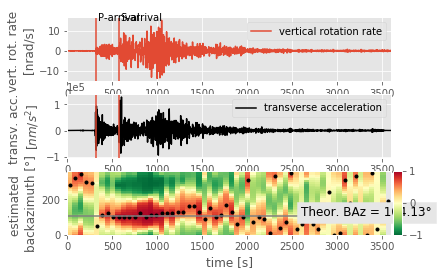

In [6]:
import matplotlib as mpl

time = np.linspace(0, len(AC[0].data)/sampling_rate,len(AC[0].data)) ## Time-array
# vertical rotation rate
plt.subplot2grid((3, 30), (0, 0), colspan=29)
plt.plot(time, RLAS[0].data,label='vertical rotation rate')
plt.xlim(0, time[-1])
plt.ylabel('vert. rot. rate \n[nrad/s]')
plt.legend()

# add P- and S-wave arrivals
plt.axvline(arriv_p);plt.annotate('P-arrival', xy=(arriv_p+20,np.max(RLAS[0].data)),xycoords='data');
plt.axvline(arriv_s);plt.annotate('S-arrival', xy=(arriv_s+20,np.max(RLAS[0].data)),xycoords='data');

# transverse acceleration
plt.subplot2grid((3, 30), (1, 0), colspan=29)
plt.plot(time, AC[0].data, 'k',label='transverse acceleration')
plt.xlim(0, time[-1])
plt.ylabel('transv. acc. \n[$nm/s^2$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.legend()
plt.axvline(arriv_p)
plt.axvline(arriv_s)

# backazimuth estimation plot
plt.subplot2grid((3, 30), (2, 0), colspan=29)
im = plt.pcolor(X, Y, corrbaz, cmap=plt.cm.RdYlGn_r, vmin=-1,vmax=1)
plt.plot(np.arange(sec/2., sec * num_windows, sec), maxcorr, '.k')
plt.xlim(0, time[-1])
plt.ylim(0, 360)
plt.ylabel(u'estimated \nbackazimuth [°]')
plt.xlabel('time [s]')

# plot theoretical Backazimuth for comparison
xx = np.arange(0, sec * num_windows + 1, sec)
tba = np.ones(len(xx)) * baz[2]
plt.plot(xx, tba, c='.5', lw=1.5)
plt.text(2600, 106, u'Theor. BAz = '+str(round(baz[2],2))+'°', color='k',fontsize=12,backgroundcolor='.9')


# add colorbar
fig = plt.subplot2grid((3, 30), (2, 29))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(fig, cmap=plt.cm.RdYlGn_r, norm=norm, orientation='vertical')


### References
<ul>
    Beyreuther, M., R. Barsch, L. Krischer, T. Megies, Y. Behr and J. Wassermann (2010)<br>
    <a href=http://www.seismosoc.org/Publications/SRL/SRL_81/srl_81-3_es/>ObsPy: A Python Toolbox for Seismology</a> <br>
    SRL, 81(3), 530-533, doi:10.1785/gssrl.81.3.530<br>
    <br>
    Igel, H., A. Cochard, J. Wassermann, A. Flaws, U. Schreiber, A. Velicoseltsev and N. Pham Dinh (2007)<br>
    <a href= http://gji.oxfordjournals.org/content/168/1/182.long>
    Broad-band observations of earthquake-induced rotational ground motions,</a> <br>
    GJI, 168(1):182-196, doi: 10.1111/j.1365-246X.2006.03146.x<br>
    <br>
    Krischer, L., T. Megies, R. Barsch, M. Beyreuther, T. Lecocq, C. Caudron, J. Wassermann (2015)<br>
    <a href=http://iopscience.iop.org/article/10.1088/1749-4699/8/1/014003/meta;jsessionid=429E7836F3590551E4FF9EE94853C476.c5.iopscience.cld.iop.org>
    ObsPy: a bridge for seismology into the scientific Python ecosystem</a><br>
    Computational Science & Discovery, 8(1), 014003, doi:10.1088/1749-4699/8/1/014003<br>
    <br>
    McLeod, D., G. Stedman, T. Webb and U. Schreiber (1998)<br>
    <a href= http://www.bssaonline.org/content/88/6/1495.short>
    Comparison of standard and ring laser rotational seismograms,</a> <br>
    Bulletin of the Seismological Society of America, 88(6):1495-1503<br>

    Megies, T., M. Beyreuther, R. Barsch, L. Krischer, J. Wassermann (2011)<br>
    <a href=http://www.annalsofgeophysics.eu/index.php/annals/article/view/4838>
    ObsPy – What can it do for data centers and observatories?</a> <br>
    Annals Of Geophysics, 54(1), 47-58, doi:10.4401/ag-4838<br>
    <br>
    Pancha, A., T. Webb, G. Stedman, D. McLeod and U. Schreiber (2000)<br>
    <a href= https://www.researchgate.net/profile/K_Schreiber/publication/228952331_Ring_laser_detection_of_rotations_from_teleseismic_waves/links/0fcfd50e570ffb5944000000.pdf>
    Ring laser detection of rotations from teleseismic waves,</a> <br>
    Geophysical Research Letters, 27(21):3553-3556<br>
</ul>